## AutoEncoder 구현

In [31]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch import nn, optim
from torchvision import transforms, datasets

In [32]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [33]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root      = '../PaperWithCode/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
autoencoder = Autoencoder().to(DEVICE)                              #DEVICE로 모델전달 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)    #Optimizer : Adam
criterion = nn.MSELoss()                                            #loss function : MSE 

In [8]:
view_data = trainset.data[:5].view(-1, 28*28) # 원본 이미지를 시각화 하기 (첫번째 열)
view_data = view_data.type(torch.FloatTensor)/255. #FloatTensor로 전환 후 0과 1사이의 값을 갖기 위해 255.0 으로 나눔

In [35]:
def train(autoencoder, train_loader):
    autoencoder.train()             # train mode
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)     
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # 원본과 디코딩 결과의 차이
        optimizer.zero_grad()        # 가중치 초기화
        loss.backward()              # 역전파
        optimizer.step()             # 가중치 갱신

[Epoch 1]


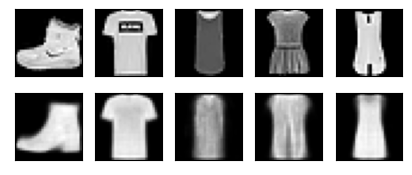

[Epoch 2]


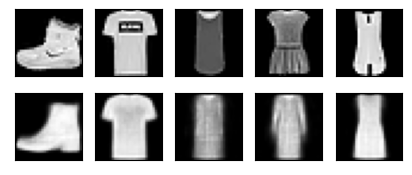

[Epoch 3]


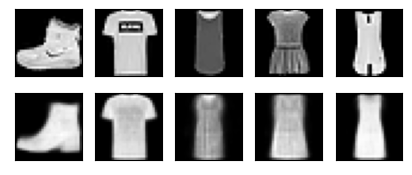

[Epoch 4]


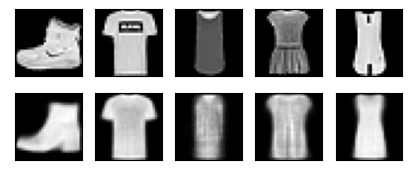

[Epoch 5]


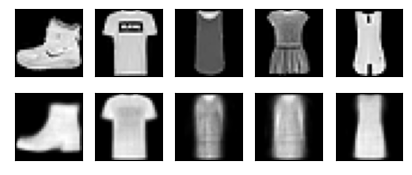

[Epoch 6]


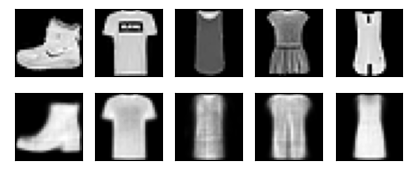

[Epoch 7]


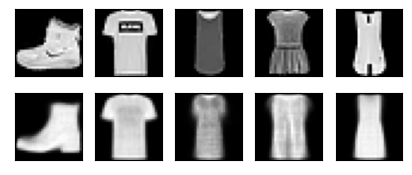

[Epoch 8]


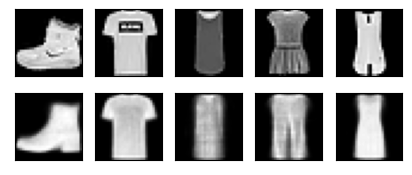

[Epoch 9]


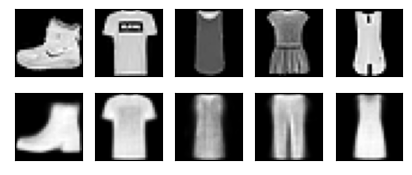

[Epoch 10]


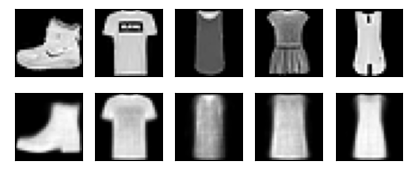

In [38]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)    # 모델 훈련

    test_x = view_data.to(DEVICE)         # view_data를 test data로 사용하기 위해 cuda에 올림. 
    _, decoded_data = autoencoder(test_x) # decoded_data를 output으로 받음, encoded data를 필요없기에 _으로 버림. 

    
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.detach().numpy()[i],(28, 28)) #.detach() : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성(일종의 복사)
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").detach().numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

## 잠재변수를 3D 플롯으로 시각화


In [17]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [18]:
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

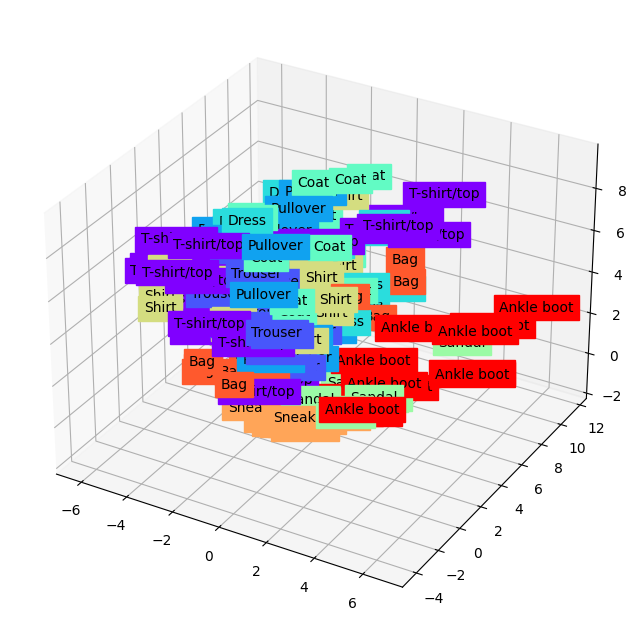

In [40]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax =plt.subplots(figsize=(10,8), subplot_kw={"projection":"3d"})

X = encoded_data.detach()[:, 0].numpy()
Y = encoded_data.detach()[:, 1].numpy()
Z = encoded_data.detach()[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

## Noise 추가 후 reconstruction

In [47]:
print(trainset.targets[0])

tensor(9)


In [48]:
encoded_data.detach()[:, 0].numpy()

array([ 4.111473  , -6.3978157 , -2.1964006 , -4.3143935 , -1.7267119 ,
       -0.80581605,  0.7343068 , -2.6225739 ,  1.3999124 ,  1.9622453 ,
       -5.856971  ,  7.318354  ,  0.28894722,  0.25078052, -0.20401134,
        2.966092  , -5.9378467 , -6.572658  ,  0.12402001, -0.12249491,
       -5.981888  , -5.409333  , -0.6116284 ,  0.30522633, -0.6307503 ,
       -4.657954  , -4.2769036 , -1.2041316 , -0.881613  , -0.05161542,
       -0.1108681 , -0.66368437,  0.8663162 , -0.4848835 , -1.82374   ,
        2.0453153 ,  4.5466614 , -0.58020365, -5.11872   ,  0.4289723 ,
        0.18718839,  0.4583078 ,  2.883483  ,  0.37313843,  4.6175566 ,
        0.04933327,  0.39533567, -6.0333214 , -5.1206827 , -4.1992383 ,
       -4.040778  , -3.310628  ,  0.6582011 , -0.55748504, -0.39404887,
       -6.0521708 , -5.427527  ,  0.8112973 , -2.0698743 , -1.7939367 ,
        3.4246087 , -4.275258  , -0.07678193, -0.570096  ,  0.2776519 ,
        0.03215075, -6.814549  ,  0.321931  , -0.7983673 , -3.37